## Matrix Completion Problem using Deep Neural Networks | Mostafa Alkady

## Machine Learning for Physicists and Mathematicians Summer School 2025 at Northeastern University

**Problem Statement:**

Given a partially observed square matrix $M \in \mathbb{R}^{n \times n}$, where only a subset of entries $(i, j) \in \{1, \dots, n\} \times \{1, \dots, n\}$ are known, the goal is to recover the full matrix by estimating the missing entries. This is typically done under the assumption that the true underlying matrix is $\textit{low-rank}$, i.e.,
$$\text{rank}(M) \ll \min(m, n).$$

Here we use a deep neural network for the prediction of the missing entries!

**Importing the packages:**

In [2]:
# NN packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Loading data
from torch.utils.data import TensorDataset, DataLoader

# Other packages for plotting and data maipulation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(17)

# Detect CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


**Create the synthetic data:**

We generate random matrices $A$ of size $n$ and rank $r$ by generating two matrices $U$ and $V$ with dimensions $(n,r)$. We then have
$$ A = U V^T, $$
which has rank $r$.

Note that the masked entries of the matrix must be $\leq n^2 - 2nr + r^2$.

In [ ]:
def generate_masking_array(n, m):
  ''' a function to generate a binary array of size n and number of zeros ranging from 1 to m '''
    # Ensure m is not greater than n and at least 1
    m = min(m, n)
    num_zeros = np.random.randint(1, m + 1)  # Random number of zeros from 1 to m
    num_ones = n - num_zeros

    # Create the array
    array = [0] * num_zeros + [1] * num_ones
    np.random.shuffle(array)  # Shuffle to randomize positions

    return np.array(array)

In [ ]:
num = 12000 # number of data points (matrices)
n = 4 # dimenion of the square matrix
r = 2 # rank of the matrices
max_masking = n**2 - 2*n*r + r**2

x_vecs = []
labels = []
mask = generate_masking_array(n**2, max_masking)
masked_indices = np.array(np.argwhere(mask == 0)).flatten()
unmasked_indices = np.array(np.argwhere(mask == 1)).flatten()

print(f"Number of masked entries: {len(masked_indices)}")

for i in range(0, num):
  U = np.random.randn(r,n)
  V = np.random.randn(r,n)
  mat = U.T @ V
  mat_column = mat.reshape(-1)
  x_vec = mat_column[unmasked_indices]
  x_vecs.append(x_vec)
  labels.append(mat_column[masked_indices])

x_vecs = np.array(x_vecs)
labels = np.array(labels)

Number of masked entries: 3


Getting the data ready for PyTorch:

In [ ]:
xs, ys = torch.tensor(x_vecs, dtype=torch.float32, device=device), torch.tensor(labels, dtype=torch.float32, device=device)

# randomly scramble xs and ys, but make sure that the labels keep aligned with the corresponding features
rand_scramble = np.random.permutation(len(xs))
xs, ys = xs[rand_scramble], ys[rand_scramble]

# perform train-test split 90:10
x_train, x_test = xs[:int(.9 * len(xs))], xs[int(.9 * len(xs)):]
y_train, y_test = ys[:int(.9 * len(xs))], ys[int(.9 * len(xs)):]
print(f"Train Features: {x_train.shape}, Train Labels: {y_train.shape}")
print(f"Test  Features: {x_test.shape}, Test  Labels: {y_test.shape}")

# we can put these into a data loader that provides batches of (x,y) pairs of the specified size
# to keep the (x,y)-pairs together we first create a tensor dataset
# also, torch wants the output to be 1D vectors rather than scalars, so we need to change [y0, y1, ...] to [[y0], [y1], ...]
# we can do this with unsqueeze()
tensor_train, tensor_test = TensorDataset(x_train, y_train.unsqueeze(-1)), TensorDataset(x_test, y_test.unsqueeze(-1))
train_loader, test_loader = DataLoader(tensor_train, batch_size=64, shuffle=True), DataLoader(tensor_train, batch_size=1000, shuffle=False)

Train Features: torch.Size([10800, 13]), Train Labels: torch.Size([10800, 3])
Test  Features: torch.Size([1200, 13]), Test  Labels: torch.Size([1200, 3])


**Creating the model:**

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(len(unmasked_indices), 30*n**2)
        self.fc2 = nn.Linear(30*n**2, 20* n**2)
        self.fc3 = nn.Linear(20*n**2, 5* n**2)
        self.fc4 = nn.Linear(5* n**2, len(masked_indices))

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
# Instantiate the model
model = SimpleMLP().to(device)

# now we can apply it to our train data. since it is not trained, the output will be random (as the weights and biases were initialized ranodmly)
# y_hats = model(xs)
# print("\nExample Output:")
# print(f"f({xs[0,0].item():.4f}, {xs[0,1].item():.4f}) = {y_hats[0].item():.4f}")

**Training:**

In [ ]:
# We train the model with MSE Loss and use stochastic gradient descend
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# a simple train loop that keeps track of the accuracies. We also plot the NN output every 10 epochs
def train_model(model, train_loader, test_loader, epochs=100, plot_interval=10):
    # To track training progress
    training_history = {
        'train_loss': [],
        'test_loss': []
    }

    for epoch in range(epochs):
        if epoch % 1000 == 0:
           print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()  # set into training mode, activates dropouts for example.
        epoch_train_loss = 0

        # Training loop
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            outputs = outputs.unsqueeze(-1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track train loss
            epoch_train_loss += loss.item()

        epoch_train_loss /= len(train_loader)
        training_history['train_loss'].append(epoch_train_loss)

        # Evaluate on test set
        model.eval()  # set into eval mode, deactivates dropouts for example.
        epoch_test_loss = 0
        xs_test, ys_test = [], []
        for i, (inputs, labels) in enumerate(test_loader):
            # no backward pass or optimization step for test!
            xs_test.append(inputs.cpu().detach())
            with torch.no_grad():
                outputs = model(inputs)
                outputs = outputs.unsqueeze(-1)
                ys_test.append(outputs.cpu().detach())
                loss = criterion(outputs, labels)
                epoch_test_loss += loss.item()

        epoch_test_loss /= len(test_loader)

        # combine batches into one torch tensor
        xs_test = torch.cat(xs_test, dim=0)
        ys_test = torch.cat(ys_test, dim=0).squeeze()
        training_history['test_loss'].append(epoch_test_loss)

    return model, training_history

epochs = 8000
model, hist = train_model(model, train_loader, test_loader, epochs=epochs , plot_interval=10)


Epoch 1/8000

Epoch 1001/8000

Epoch 2001/8000

Epoch 3001/8000

Epoch 4001/8000

Epoch 5001/8000

Epoch 6001/8000

Epoch 7001/8000


**Plotting the train/test losses:**

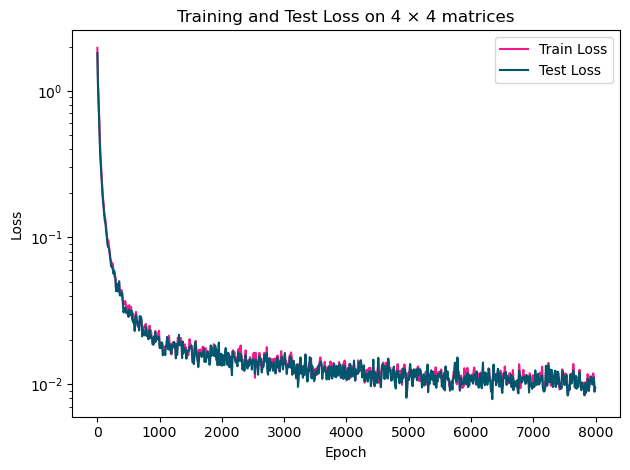

In [ ]:
step = 10
plt.plot(np.arange(1, epochs, step), hist['train_loss'][::step], label="Train Loss", color = '#ed1c88')
plt.plot(np.arange(1, epochs, step), hist['test_loss'][::step], label="Test Loss", color = '#01566d')
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training and Test Loss on {n} × {n} matrices")
plt.legend()
plt.tight_layout()
plt.show()

**Prediction:**

In [ ]:
U = np.random.randn(r,n)
V = np.random.randn(r,n)
mat = U.T @ V
mat_column = mat.reshape(-1)
x_vec = mat_column[unmasked_indices]

print("mask indices", masked_indices)
print("input:", x_vec)
print("expected:", mat_column.reshape(n,n))

example_input = torch.tensor(x_vec, dtype=torch.float32, device=device)

with torch.no_grad():
    prediction = model(example_input)

print(prediction)

mask indices [ 2 10 14]
input: [ 0.36533062 -1.04661651 -0.47209125 -1.98844479  8.74760154  0.38066227
  0.17054778 -1.15190681  4.12536361  0.83958253  0.17364828  0.41363986
 -0.94079514]
expected: [[ 0.36533062 -1.04661651 -1.06839808 -0.47209125]
 [-1.98844479  8.74760154  0.38066227  0.17054778]
 [-1.15190681  4.12536361  1.89863841  0.83958253]
 [ 0.17364828  0.41363986 -2.13071512 -0.94079514]]
tensor([-1.1168,  0.2663,  0.1812])


In [ ]:
print(f"Final Train Loss: {hist['train_loss'][-1]:.4f}")
print(f"Final Test Loss:  {hist['test_loss'][-1]:.4f}")

Final Train Loss: 0.0099
Final Test Loss:  0.0098


In [ ]:
torch.save(model.state_dict(), "4x4_new_model_weights.pth")

## Extras:

Distribution of the entries of the matrix:

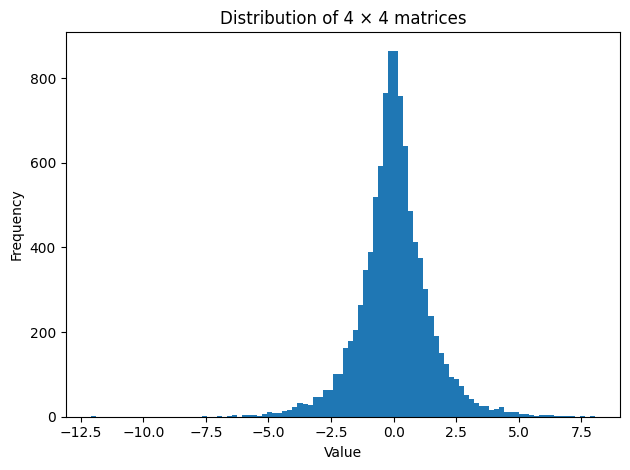

In [3]:
num = 10000 # number of data points (matrices)
n = 4 # dimenion of the square matrix
r = 2 # rank of the matrices

elem_row, elem_col = 0, 0
elements = []

for i in range(0, num):
  U = np.random.randn(r,n)
  V = np.random.randn(r,n)
  mat = U.T @ V
  elements.append(mat[elem_row, elem_col])

plt.hist(elements, bins=100);
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of {n} × {n} matrices')
plt.tight_layout()
plt.show()

**Loading the pre-trained model:**
for the 2x2 case:

In [6]:
state_dict = torch.load('2x2_model_weights.pth')
print(state_dict.keys())
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
fc1.weight: torch.Size([120, 3])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([40, 120])
fc2.bias: torch.Size([40])
fc3.weight: torch.Size([16, 40])
fc3.bias: torch.Size([16])
fc4.weight: torch.Size([1, 16])
fc4.bias: torch.Size([1])


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(3, 120)
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 16)
        self.fc4 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

model = SimpleMLP()  # define the architecture
model.load_state_dict(torch.load("2x2_model_weights.pth"))
model.eval()  # set to evaluation mode if you’re doing inference

SimpleMLP(
  (fc1): Linear(in_features=3, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=4, bias=True)
)

0.9918


(-2.0, 2.0)

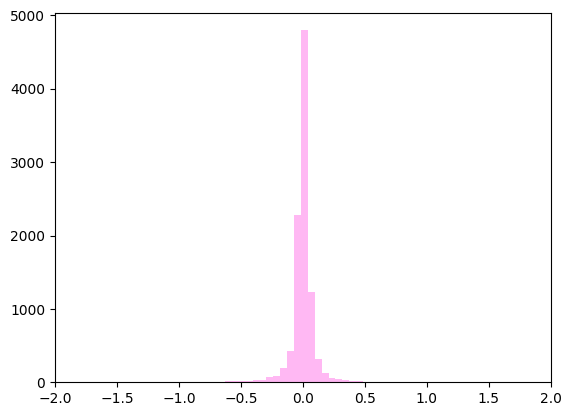

In [ ]:
num = 10000
n = 2
r = 1
max_masking = n**2 - 2*n*r + r**2
mask = generate_masking_array(n, max_masking)
mask_indices = np.array(np.argwhere(mask == 1)).flatten()
deviations = []
perc = 0
for i in range(0, num):
  U = np.random.randn(r,n)
  V = np.random.randn(r,n)
  mat = U.T @ V
  mat_column = mat.reshape(-1)
  x_vec = mat_column[mask_indices]
  example_input = torch.tensor(x_vec, dtype=torch.float32, device=device)
  with torch.no_grad():
      prediction = model(example_input)
  dev = mat_column[-1] - prediction.cpu().detach().numpy()[-1]
  if dev < 1 and dev > -1:
    perc += 1
  deviations.append(dev)

perc /= num
print(perc)
plt.hist(deviations, bins=200, color='#ffb8f3');
plt.xlim(-2, 2)

For the 4x4 case:

In [8]:
state_dict = torch.load('4x4_model_weights.pth')
print(state_dict.keys())
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
fc1.weight: torch.Size([480, 13])
fc1.bias: torch.Size([480])
fc2.weight: torch.Size([320, 480])
fc2.bias: torch.Size([320])
fc3.weight: torch.Size([80, 320])
fc3.bias: torch.Size([80])
fc4.weight: torch.Size([3, 80])
fc4.bias: torch.Size([3])


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(13, 480)
        self.fc2 = nn.Linear(480, 320)
        self.fc3 = nn.Linear(320, 80)
        self.fc4 = nn.Linear(80, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

model = SimpleMLP()  # define the architecture
model.load_state_dict(torch.load("4x4_model_weights.pth"))
model.eval()  # set to evaluation mode if you’re doing inference

SimpleMLP(
  (fc1): Linear(in_features=13, out_features=480, bias=True)
  (fc2): Linear(in_features=480, out_features=1600, bias=True)
  (fc3): Linear(in_features=1600, out_features=16, bias=True)
)

percentage within SD: 0.6844


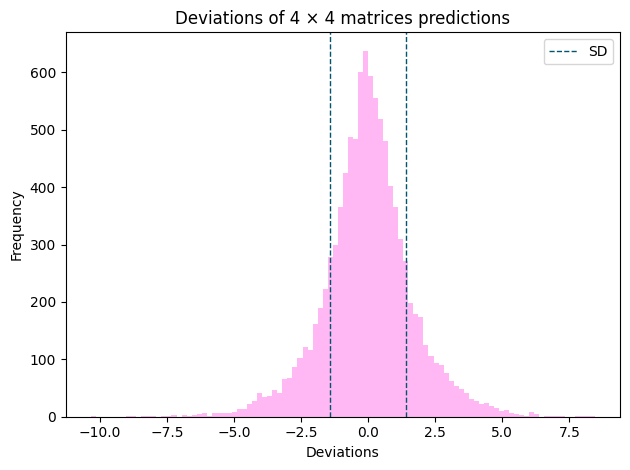

In [ ]:
num = 10000
n = 4
r = 2
ax_masking = n**2 - 2*n*r + r**2
mask = generate_masking_array(n, max_masking)
mask_indices = np.array(np.argwhere(mask == 1)).flatten()
deviations = []
perc = 0

for i in range(0, num):
  U = np.random.randn(r,n)
  V = np.random.randn(r,n)
  mat = U.T @ V
  mat_column = mat.reshape(-1)
  x_vec = mat_column[mask_indices]
  example_input = torch.tensor(x_vec, dtype=torch.float32, device=device)
  with torch.no_grad():  # No need to track gradients for prediction
      prediction = model(example_input)

  dev = mat_column[-1] - prediction.cpu().detach().numpy()[-1]
  if dev < np.sqrt(2) and dev > -np.sqrt(2):
    perc += 1
  deviations.append(dev)

perc /= num
print(f"percentage within SD: {perc}")
plt.hist(deviations, bins=100, color = "#ffb8f3");
plt.xlabel("Deviations")
plt.ylabel("Frequency")
plt.title(f"Deviations of {n} × {n} matrices predictions")
plt.axvline(x=np.sqrt(2), color='#01566d', linestyle='--', linewidth=1, label = "SD")
plt.axvline(x=-np.sqrt(2), color='#01566d', linestyle='--', linewidth=1)
plt.legend()
plt.tight_layout()
# plt.savefig("4_deviations.png")
# plt.xlim(-2, 2)